In [1]:
import numpy as np
import pandas as pd
import scipy.linalg as linalg
import torch
import matplotlib.pyplot as plt

plotscale = 10

## PCA - for Covariance matrix S

(Numerical Ecology, ch9.1)   假设有一个Species丰度矩阵Y，每行代表一个样本，每列代表一个descriptor/feature

1. centralize Y as Yc
2. S= Yc'Yc/(n-1)
3. PCA分解，得到S的特征值L[i]与特征向量U[:,i] ；(U的每一**列**为一个**特征向量**, 向量的每个元素对应一个descriptor/feature)
    - 特征值即PC_i所解释的方差
    - 特征向量的方向，即PC方向，是最大方差的方向
4. F=YcU 即PC坐标系中样本的坐标 (scaling 1)



scaling 1 -- Distance biplot；descriptor向量在PC空间相互垂直，意在展示样本在PC空间的距离

scaling 2 -- Correlationbiplot；descriptor向量在PC空间的角度是其covariance的arccosin，意在展示variance之间的关联

（p 437,442）


In [2]:
I = np.eye(2,dtype=int)
I

array([[1, 0],
       [0, 1]])

In [3]:
Y = np.matrix([[2,3,5,7,9],      ## n=5, feature=2
               [1,4,0,6,2]]).T
Y

matrix([[2, 1],
        [3, 4],
        [5, 0],
        [7, 6],
        [9, 2]])

In [4]:
Yc = Y - Y.mean(0)
Yc

matrix([[-3.2, -1.6],
        [-2.2,  1.4],
        [-0.2, -2.6],
        [ 1.8,  3.4],
        [ 3.8, -0.6]])

In [5]:
S = Yc.T @ Yc / (5-1)
S

matrix([[8.2, 1.6],
        [1.6, 5.8]])

In [6]:
linalg.eigh(S)

(array([5., 9.]),
 array([[ 0.4472136 , -0.89442719],
        [-0.89442719, -0.4472136 ]]))

In [7]:
L, U = linalg.eigh(S)
L = L[::-1]                  ## np.argsort(L)[::-1]  to descending order
U = U[:,::-1]               
U = -U if U[0,0] < 0 else U  ## 该符号只是换了PC的正反方向（pc_1_x>0），无伤大雅？？(原输出可能是按照原排序的pc_1_x决定符号)

L,U                           ## (S - L[0]*I) @ U[:,0]   ## linalg.det(S - L[1] * I)

(array([9., 5.]),
 array([[ 0.89442719, -0.4472136 ],
        [ 0.4472136 ,  0.89442719]]))

In [8]:
F = Yc @ U             ## Scale 1 PC-axis 上样本的坐标
F                      ## F.var(0) should be lambda ([9,5]) but ???

matrix([[-3.57770876e+00, -2.22044605e-16],
        [-1.34164079e+00,  2.23606798e+00],
        [-1.34164079e+00, -2.23606798e+00],
        [ 3.13049517e+00,  2.23606798e+00],
        [ 3.13049517e+00, -2.23606798e+00]])

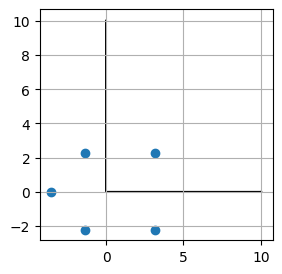

In [9]:
fig=plt.figure(figsize=(3,3))
ax = plt.axes()
ax.arrow(plotscale*0, plotscale* 0, plotscale*1, plotscale*0, length_includes_head=False,head_width=0.05, fc='b', ec='k')  
ax.arrow(plotscale*0, plotscale* 0, plotscale*0, plotscale*1, length_includes_head=False,head_width=0.05, fc='b', ec='k')  
ax.grid()

plt.scatter(np.array(F[:,0]).squeeze(),np.array(F[:,1]).squeeze())

PC1: (0,0) to (0.8944271909999159,0.4472135954999578)
PC2: (0,0) to (-0.4472135954999578,0.8944271909999159)


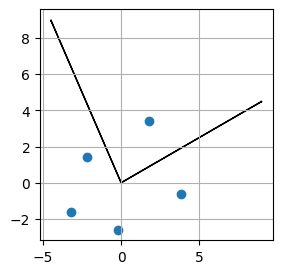

In [10]:
fig=plt.figure(figsize=(3,3))   ## ?? 应该是垂直的啊   np.dot(U[:,0],U[:,1]) == 0  且 np.arccos(U)/np.pi*180 后 gamma+sigma = 90
ax = plt.axes()
ax.arrow(0, 0, plotscale*U[:,0][0], plotscale*U[:,0][1], length_includes_head=False,head_width=0.05, fc='b', ec='k')   ## PC1
ax.arrow(0, 0, plotscale*U[:,1][0], plotscale*U[:,1][1], length_includes_head=False,head_width=0.05, fc='b', ec='k')   ## PC2
ax.grid()

print('PC1: (0,0) to ({},{})'.format(U[:,0][0],U[:,0][1]))
print('PC2: (0,0) to ({},{})'.format(U[:,1][0],U[:,1][1]))

plt.scatter(np.array(Yc[:,0]).squeeze(),np.array(Yc[:,1]).squeeze())

### Scaling 1

* UU'=I（即特征向量特征向量之间的cos角度=90, i.e.相互垂直） 且 U中每行/列元素的平方和=1

* **u_jk** 表示 descriptor-axis j 在 PC-axis k 上的投影，与 covariance(descriptor,PC) 等比例
    - ???由于每个PC-axis的proportion factor（可能是sqrt(L_k)??）不一样，故分析时只需比较同一PC-axis内的信息即可

* equilibrium contribution: sqrt(d/p)
    - p维原始空间(即p个descriptor)的单位向量 isogonal projection 至 d维目标空间中，每个目标空间的axis平均接受到原向量 sqrt(d/p) 的长度  （P437）
    - 用以评估每个descriptor对PC的贡献：此例中，如果需要验证某个descriptor（共p=2）对单个PC（d=1）是否重要，则若 u_jk > sqrt(1/2)，descriptor j 对 PC k 而言很重要


In [11]:
U @ U.T 

array([[1., 0.],
       [0., 1.]])

In [12]:
np.square(U).sum(0)              ## 每一列平方和    'Length of scaled eigenvectors' ^2

array([1., 1.])

In [13]:
np.square(U).sum(1)              ## 每一行平方和     'Length of descriptor j in U or U_' ^2   -- descriptor j 在此PC上所解释的variance比例？？

array([1., 1.])

In [14]:
np.arccos(U)/np.pi*180        ## y1------>PC1------>y2------>PC2
                        ## angles:  beta     gamma     sigma
## beta     ?
## gamma  sigma

array([[ 26.56505118, 116.56505118],
       [ 63.43494882,  26.56505118]])

### Scaling 2

* U_ = U @ sqrt(L)
* U_U_'=S，即特征向量之间的cos角度取决于二者的covariance
* 用于研究descriptor/feature间的关系
* **u_ _jk** = **u_jk** * sqet(L_k)，展示了 covariance(descriptor,PC) ？？
* equilibrium contribution: s_j * sqrt(d/p)


In [15]:
U_ = U @ np.diag(np.sqrt(L))      

In [16]:
U_ @ U_.T                         ## equals to S

array([[8.2, 1.6],
       [1.6, 5.8]])

In [17]:
np.square(U_).sum(0)              ## 每一列平方和 = Lambda

array([9., 5.])

In [18]:
np.square(U_).sum(1)              ## 每一行平方和 = s_j ^2  

array([8.2, 5.8])

In [19]:
s = np.square(U_).sum(1)  ** 0.5    ## s_j  即这些向量在多维空间中的标准距离/Standard Deviation
s

array([2.86356421, 2.40831892])

In [20]:
R = np.array([U_[d] / s[d] for d in range(2)])       ## correlations between descruptors
R

array([[ 0.93704257, -0.34921515],
       [ 0.55708601,  0.8304548 ]])

In [21]:
np.arccos(R)/np.pi*180        ## y1------>PC1------>y2------>PC2
                        ## angles:  beta     gamma     sigma
## beta     ?
## gamma  sigma

array([[ 20.43931757, 110.43931757],
       [ 56.14548519,  33.85451481]])

In [22]:
G = F @ np.diag(1/np.sqrt(L))     ## Scale 2 PC-axis 上样本的坐标
G

matrix([[-1.19256959e+00, -9.93013661e-17],
        [-4.47213595e-01,  1.00000000e+00],
        [-4.47213595e-01, -1.00000000e+00],
        [ 1.04349839e+00,  1.00000000e+00],
        [ 1.04349839e+00, -1.00000000e+00]])

## PCA - for correlation matrix R

1. 对Y计算correlation matrix R  for descriptors (而不是上文的Covariance S)，R的对角元素都=1    （p 446）
2. 对Y计算标准化后的 Yc = [Y - Y_mean] / s_y
3. 对 R 进行分解，得到特征向量的矩阵 U
4. F = YcU

区别：
* R=Z'Z/(n-1)，只是在计算S前加了一步Y标准化
* S_eigenvalue 之和 = variance s^2; 但 R_eigenvalue 之和 = p (原始空间维度)
* 样本在S所得PC空间保留欧式距离；而在R所得PC空间则不是
* 用例：
    - S: preserving descriptors’ differences in magnitude
    - R: descriptors contribute equally to the clustering of objects



## 关于Vegan

```R
library(vegan)
A = t(matrix( c(2,3,5,7,9,1,4,0,6,2), ncol = 5,byrow = TRUE))
res <- prcomp(A,center = TRUE, scale= FALSE)
res$x    ## m_Sample在PC上的坐标
res$rotation  ## U
```

eigenvalue就是各PC所解释的Variance比例（importance）。
```
> summary(res)$importance
                           PC1      PC2
Standard deviation     3.00000 2.236068    ---->   sqrt(9)   sqrt(5)
Proportion of Variance 0.64286 0.357140    ---->   9/(9+5)   5/(9+5)
Cumulative Proportion  0.64286 1.000000
```
